In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import sklearn
import matplotlib

matplotlib.rcParams.update({
    'font.size':18,
    'legend.fontsize':20,
    'axes.labelsize':12,
    'figure.titlesize':22,
    'lines.linewidth': 2.5,
    'lines.markersize': 12.0
})
#matplotlib.rcParams
import importlib
import data
importlib.reload(data)
from data import *

Text(0.5,1,'Time 0 is the time when the first case was reported\n SIR model shifted so that both start at 1e-5')

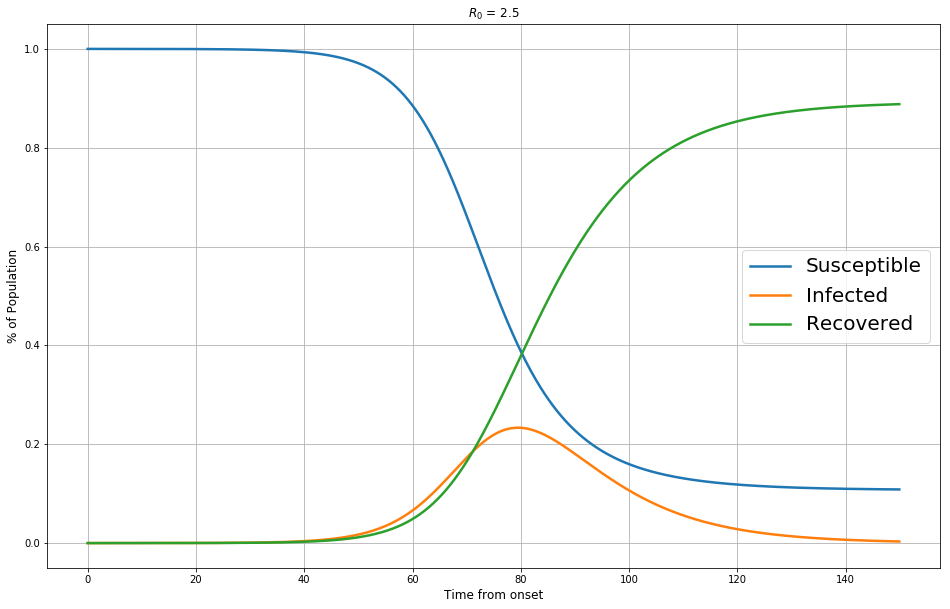

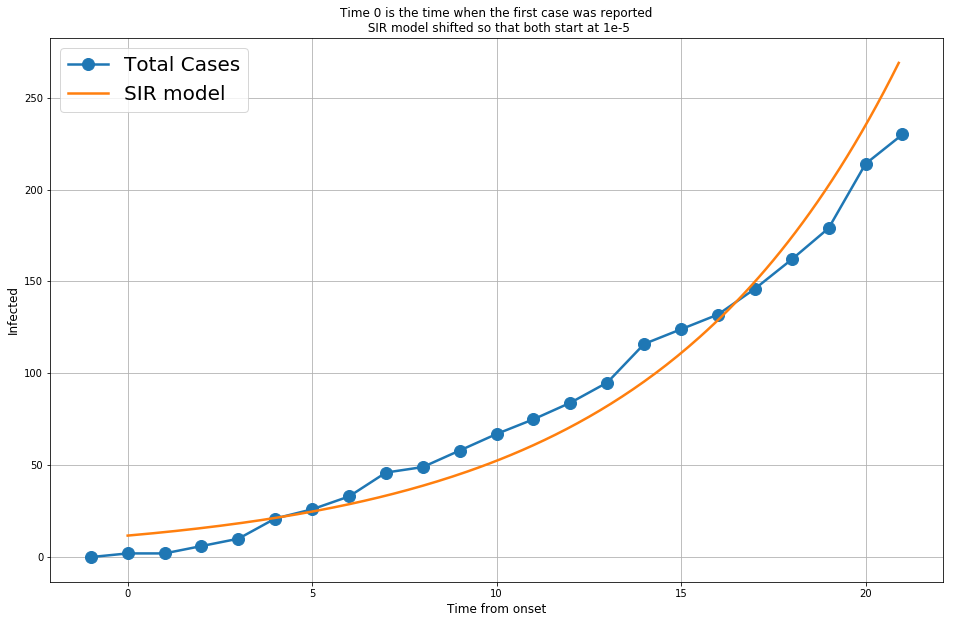

In [2]:
N = 1.00
Istart = 10e-6        #infected
Sstart = N - Istart  #susceptible 
Rstart = 0.0           #recovered = not susceptible or indected (counts both deaths and actual recoveries)

transmisivity = 0.25     #how fast the virus is transmitted
recovery = 0.10   #how fast people heal
maxTime = 150
t = np.arange(0,maxTime, 0.1)

def susceptibleROC(t, S,I,R, transmisivity, recovery):
    return - transmisivity*S*I

def infectedROC(t, S,I,R, transmisivity, recovery):
    return transmisivity*S*I - recovery*I

def recoveredROC(t, S,I,R, transmisivity, recovery):
    return recovery*I

def SIRmodel(y,t,params):
    S,I,R = y
    transmisivity,recovery = params
    derivs = [susceptibleROC(t,S,I,R,transmisivity, recovery), 
              infectedROC(t,S,I,R,transmisivity, recovery),
              recoveredROC(t,S,I,R,transmisivity, recovery)]
    return derivs

from scipy.integrate import odeint

y0 = [Sstart,Istart,Rstart]
params = [transmisivity, recovery]
sol = odeint(SIRmodel, y0, t, args=(params,))
inf = sol[:,1]
plt.figure(figsize=(16,10))
plt.plot(t, sol[:,0], label='Susceptible')
plt.plot(t,sol[:,1], label='Infected')
plt.plot(t,sol[:,2], label='Recovered')

plt.grid(True)
plt.ylabel('% of Population')
plt.xlabel('Time from onset')

plt.title('$R_0$ = %s'%(transmisivity/recovery)) 
plt.legend(loc='best')

plt.figure(figsize=(16,10))

plt.plot(days_from_onset, total_cases, 'o-', label='Total Cases')
plt.plot(t[t<days_from_onset[-1]], inf[t<days_from_onset[-1]]*1.17e6, label='SIR model')
plt.legend(loc='best')
plt.xlabel('Time from onset')
plt.ylabel('Infected')
plt.grid(True)
plt.title('Time 0 is the time when the first case was reported\n SIR model shifted so that both start at 1e-5')



$R_0$ of COVID-19 has been estimated to be between **1.4** and **3.9**. The exact number is not  available or known in cyprys. 

Text(0.5,1,'The big picture according to the SIR model')

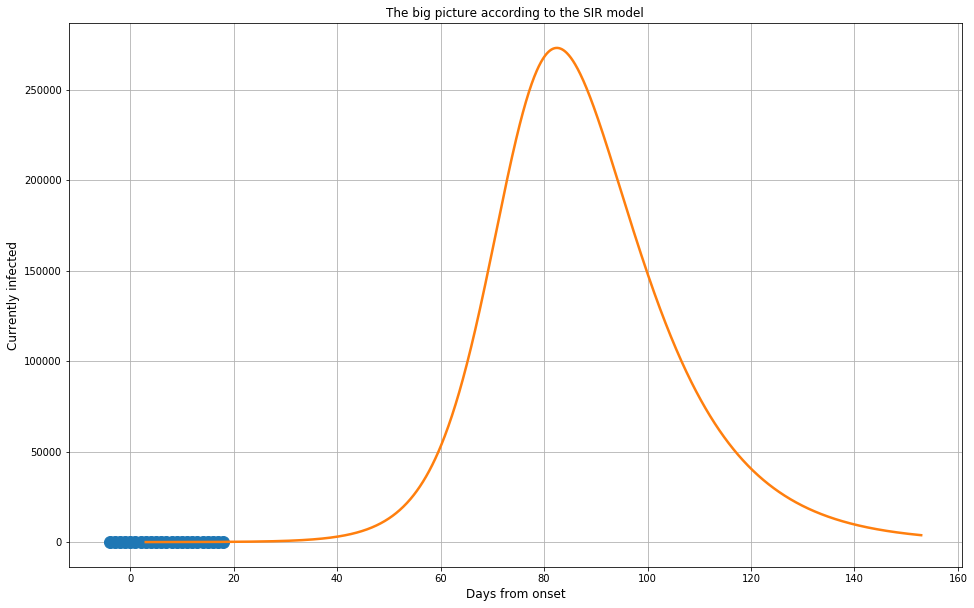

In [3]:
plt.figure(figsize=(16,10))
plt.plot(days_from_onset-3, total_cases, 'o-', label='Total Cases')
plt.plot(t+3, inf*1.17e6, label='SIR model')
plt.xlabel('Days from onset')
plt.ylabel('Currently infected')
plt.grid(True)
plt.title('The big picture according to the SIR model')

According to the current parameters of the SIR model, which were manually optimized, we are still early in the spread of COVID-19. The time from the start of the epidemic to the peak is not yet known as only China has passed through the whole cycle of the pandemic. The time is also probably affected by the measures each country takes. As more data are added the SIR model will be re-calibrated. 

## Optimizing the parameters of the model 

In [4]:
def g(x, trans, recov):
    y0 = [Sstart,Istart,Rstart]
    params = [trans, recov]
    sol = odeint(SIRmodel, y0, t, args=(params,))
    inf = sol[:,1]
    s = inf[np.in1d(t,x)]
    return s

[7.00305488 6.84677688]


Text(0.5,1,'The big picture according to the SIR model')

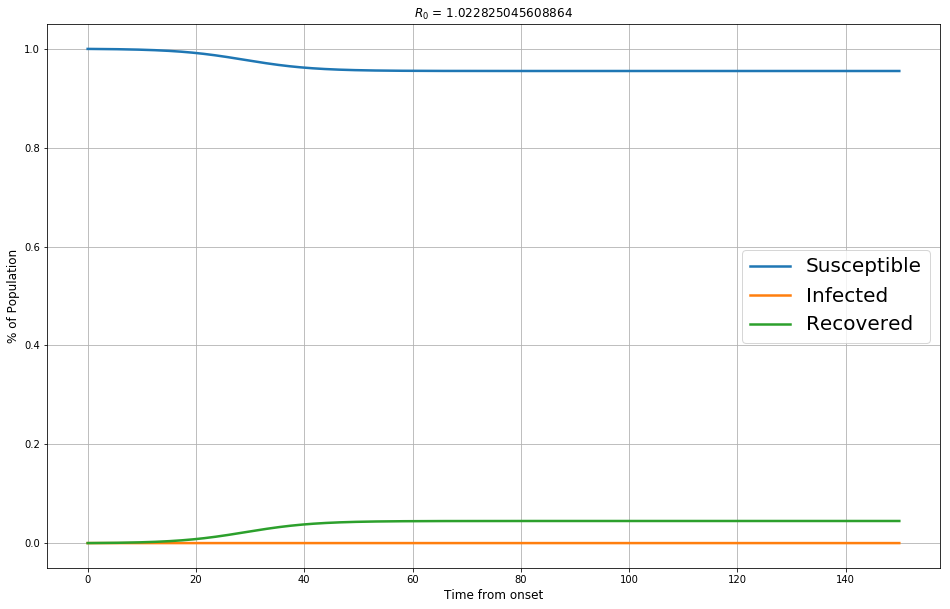

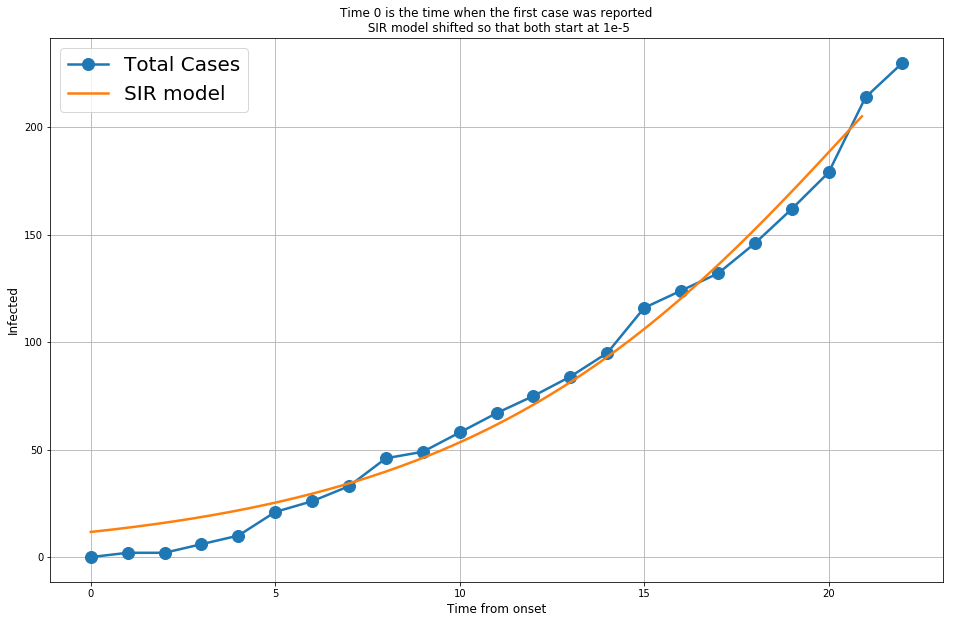

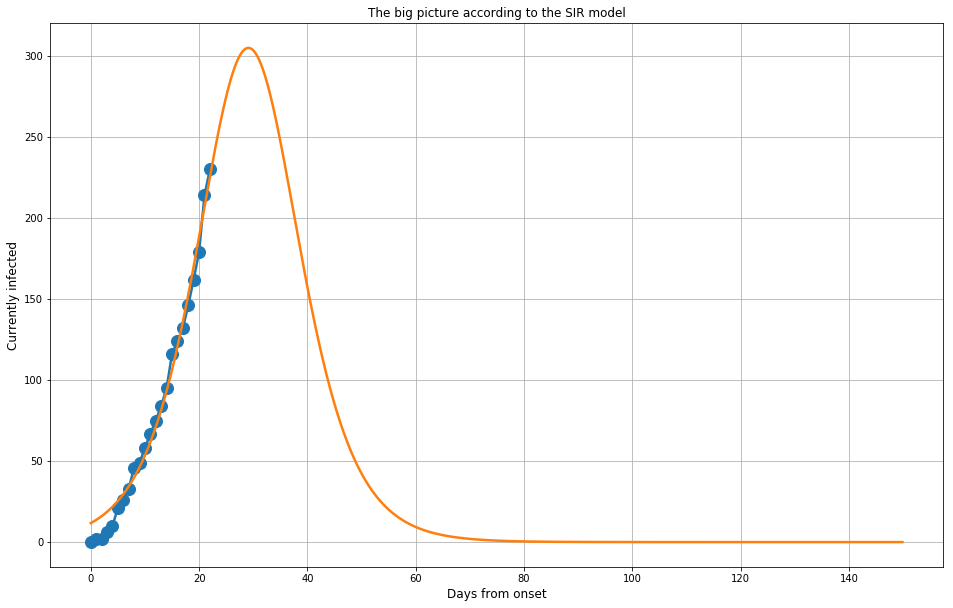

In [5]:
from scipy.optimize import curve_fit

ppot,pcov = curve_fit(g,days_from_onset+1, total_cases/1.17e6, p0=[10,10])
print(ppot)

params =  ppot
sol = odeint(SIRmodel, y0, t, args=(params,))
inf = sol[:,1]
plt.figure(figsize=(16,10))
plt.plot(t, sol[:,0], label='Susceptible')
plt.plot(t,sol[:,1], label='Infected')
plt.plot(t,sol[:,2], label='Recovered')

plt.grid(True)
plt.ylabel('% of Population')
plt.xlabel('Time from onset')

plt.title('$R_0$ = %s'%(ppot[0]/ppot[1])) 
plt.legend(loc='best')

plt.figure(figsize=(16,10))

plt.plot(days_from_onset+1, total_cases, 'o-', label='Total Cases')
plt.plot(t[t<days_from_onset[-1]], inf[t<days_from_onset[-1]]*1.17e6, label='SIR model')
plt.legend(loc='best')
plt.xlabel('Time from onset')
plt.ylabel('Infected')
plt.grid(True)
plt.title('Time 0 is the time when the first case was reported\n SIR model shifted so that both start at 1e-5')

plt.figure(figsize=(16,10))
plt.plot(days_from_onset+1, total_cases, 'o-', label='Total Cases')
plt.plot(t, inf*1.17e6, label='SIR model')
plt.xlabel('Days from onset')
plt.ylabel('Currently infected')
plt.grid(True)
plt.title('The big picture according to the SIR model')

Fitting the model to the data produced some overly optimistic results. The optimal set of parameter found from fitting also depends on the initial conditions. Overall more points are needed to have a more accurate picture of the trend. 

# Fitting the initial conditions as well

In [6]:
def g(x, trans, recov, Is):
    y0 = [1-Is,Is,0.0]
    params = [trans, recov]
    sol = odeint(SIRmodel, y0, t, args=(params,))
    inf = sol[:,1]
    s = inf[np.in1d(t,x)]
    return s

/usr/lib64/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in double_scalars


[7.75896972e+00 7.59368420e+00 8.95039284e-06]


Text(0.5,1,'The big picture according to the SIR model')

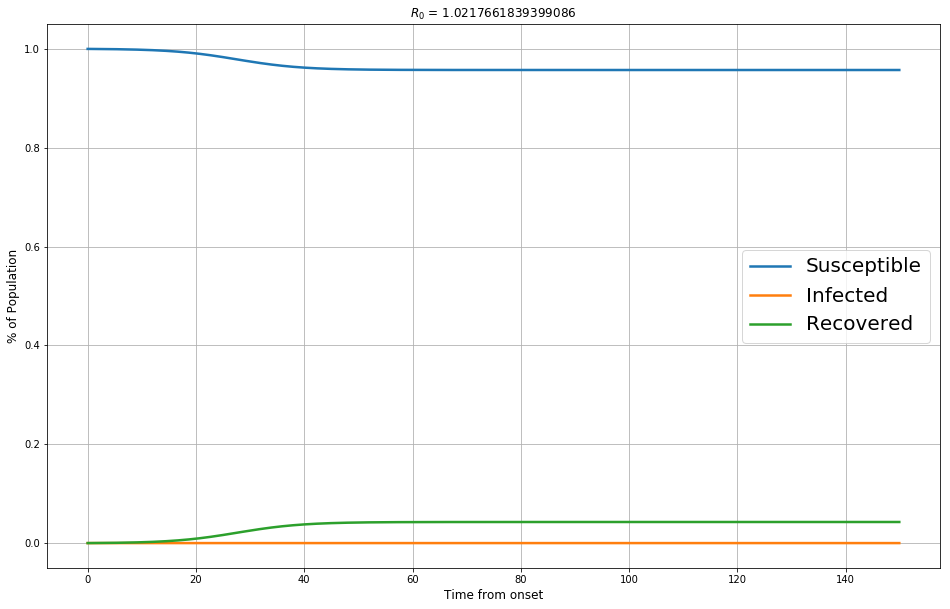

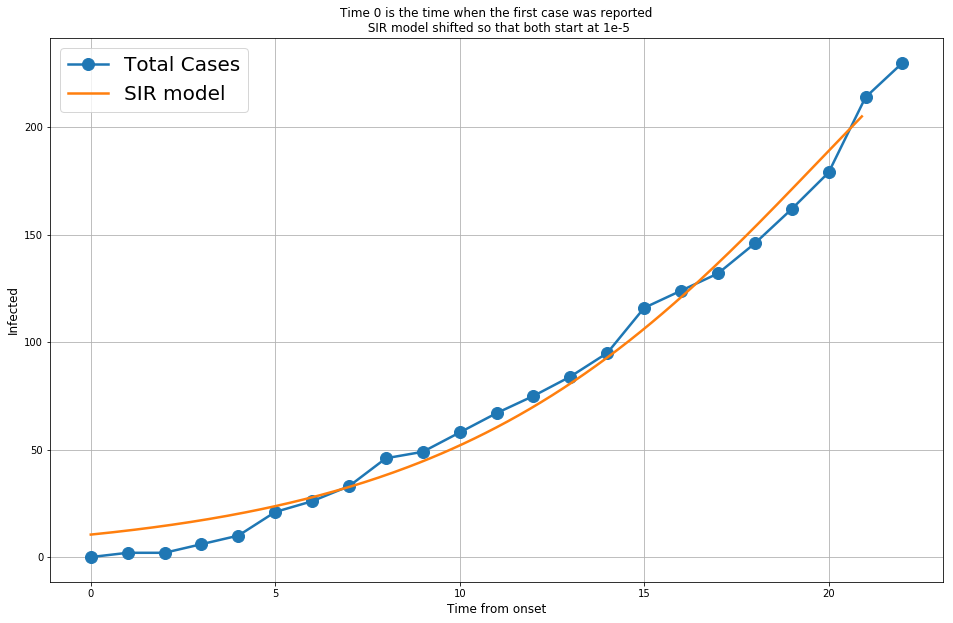

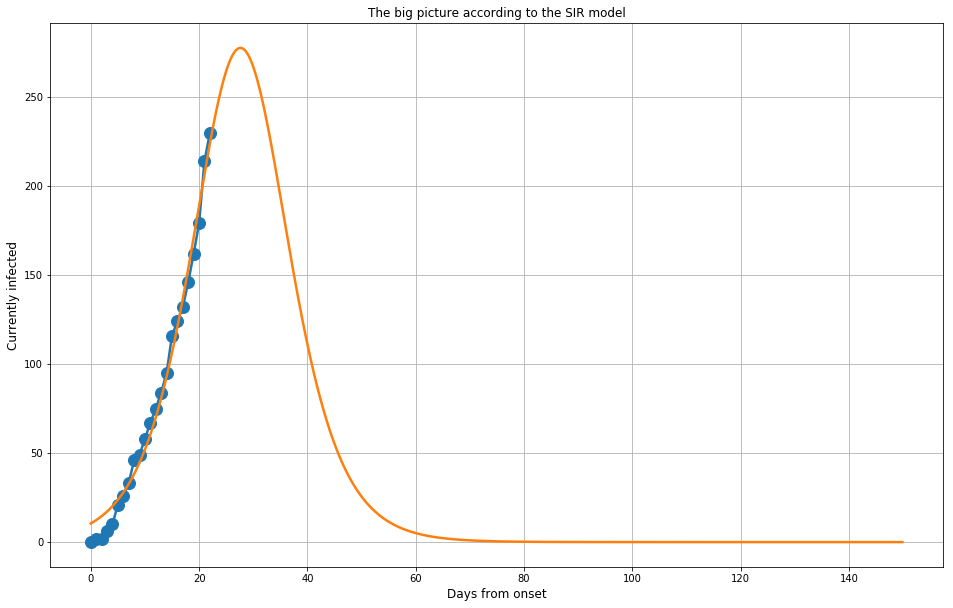

In [10]:
from scipy.optimize import curve_fit

ppot,pcov = curve_fit(g,days_from_onset+1, total_cases/1.17e6, p0=[10,10,1e-5])
print(ppot)

params =  ppot
Istart = ppot[2]
y0 = [Sstart,Istart,Rstart]
sol = odeint(SIRmodel, y0, t, args=(params[:2],))
inf = sol[:,1]
plt.figure(figsize=(16,10))
plt.plot(t, sol[:,0], label='Susceptible')
plt.plot(t,sol[:,1], label='Infected')
plt.plot(t,sol[:,2], label='Recovered')

plt.grid(True)
plt.ylabel('% of Population')
plt.xlabel('Time from onset')

plt.title('$R_0$ = %s'%(ppot[0]/ppot[1])) 
plt.legend(loc='best')

plt.figure(figsize=(16,10))

plt.plot(days_from_onset+1, total_cases, 'o-', label='Total Cases')
plt.plot(t[t<days_from_onset[-1]], inf[t<days_from_onset[-1]]*1.17e6, label='SIR model')
plt.legend(loc='best')
plt.xlabel('Time from onset')
plt.ylabel('Infected')
plt.grid(True)
plt.title('Time 0 is the time when the first case was reported\n SIR model shifted so that both start at 1e-5')

plt.figure(figsize=(16,10))
plt.plot(days_from_onset+1, total_cases, 'o-', label='Total Cases')
plt.plot(t, inf*1.17e6, label='SIR model')
plt.xlabel('Days from onset')
plt.ylabel('Currently infected')
plt.grid(True)
plt.title('The big picture according to the SIR model')

In [8]:
print(ppot[:1])

[7.75896972]
